# Exploring the trajectory of a single patient

### Import Python libraries

We first need to import some tools for working with data in Python. 
- NumPy is for working with numbers
- Pandas is for analysing data
- MatPlotLib is for making plots
- Sqlite3 to connect to the database

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

### Connect to the database

- We can use the sqlite3 library to connect to the MIMIC database
- Once the connection is established, we'll run a simple SQL query.

In [24]:
# Connect to the MIMIC database
conn = sqlite3.connect('data/mimicdata.sqlite')

In [25]:
# Create our test query
test_query = """
SELECT subject_id, hadm_id, admittime, dischtime, admission_type, diagnosis
FROM admissions
LIMIT 10;
"""

In [26]:
# Run the query and assign the results to a variable
test = pd.read_sql_query(test_query,conn)

In [27]:
# Display the first few rows
test.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,DIAGNOSIS
0,40036,198489,2141-08-01 23:46:00,2141-08-09 19:15:00,EMERGENCY,SEPSIS
1,40080,162107,2106-05-31 16:43:00,2106-06-05 01:18:00,EMERGENCY,CONGESTIVE HEART FAILURE
2,40084,195762,2173-01-31 22:11:00,2173-02-05 01:31:00,EMERGENCY,INTRACRANIAL HEMORRHAGE;OPEN FX
3,40116,157106,2150-02-19 00:12:00,2150-03-11 13:58:00,EMERGENCY,GASTROINTESTINAL BLEED
4,40120,146466,2120-01-27 20:41:00,2120-02-12 17:14:00,EMERGENCY,CONGESTIVE HEART FAILURE


### Load the chartevents data

- The chartevents table contains data charted at the patient bedside. It includes variables such as heart rate, respiratory rate, temperature, and so on.
- We'll begin by loading the chartevents data for a single patient.

In [28]:
query = """
SELECT de.icustay_id
  , (strftime('%s',de.charttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS
  , di.label
  , de.value
  , de.valuenum
  , de.uom
FROM chartevents de
INNER join d_items di
ON de.itemid = di.itemid
INNER join icustays ie
ON de.icustay_id = ie.icustay_id
WHERE de.subject_id = 40036
ORDER BY charttime;
"""

ce = pd.read_sql_query(query,conn)


In [29]:
# Preview the data
# Use 'head' to limit the number of rows returned
ce.head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUENUM,UOM
0,285485,0.403333,Lactic Acid,1.1,1.1,mmol/L
1,285485,1.553333,Heart Rate,75,75.0,bpm
2,285485,1.553333,O2 saturation pulseoxymetry,97,97.0,%
3,285485,1.553333,Admission Weight (Kg),125.8,125.8,kg
4,285485,1.553333,Admission Weight (lbs.),276.8,276.8,


### Review the patient's heart rate

- We can select individual columns using the column name. 
- For example, if we want to select just the label column, we write **```ce.LABEL```** or alternatively **```ce['LABEL']```**

In [30]:
# Select a single column
ce['LABEL']

0                                   Lactic Acid
1                                    Heart Rate
2                   O2 saturation pulseoxymetry
3                         Admission Weight (Kg)
4                       Admission Weight (lbs.)
5                                    Heart Rate
6                       Heart rate Alarm - High
7                        Heart Rate Alarm - Low
8                              Respiratory Rate
9                   O2 saturation pulseoxymetry
10     Non-Invasive Blood Pressure Alarm - High
11      Non-Invasive Blood Pressure Alarm - Low
12                       Temperature Fahrenheit
13     O2 Saturation Pulseoxymetry Alarm - High
14      O2 Saturation Pulseoxymetry Alarm - Low
15                            Resp Alarm - High
16                             Resp Alarm - Low
17                             SpO2 Desat Limit
18         Non Invasive Blood Pressure systolic
19        Non Invasive Blood Pressure diastolic
20             Non Invasive Blood Pressu

- In a similar way, we can select rows from data using indexes. 
- For example, to select rows where the label is equal to 'Heart Rate', we would create an index using **```[ce.LABEL=='Heart Rate']```** 

In [ ]:
# Select just the heart rate rows using an index
ce[ce.LABEL=='Heart Rate']

### Plot 1: How did the patients heart rate change over time?

- Using the methods described above to select our data of interest, we can create our x and y axis values to create a time series plot of heart rate.

In [ ]:
# Which time stamps have a corresponding heart rate measurement?
print ce.index[ce.LABEL=='Heart Rate']

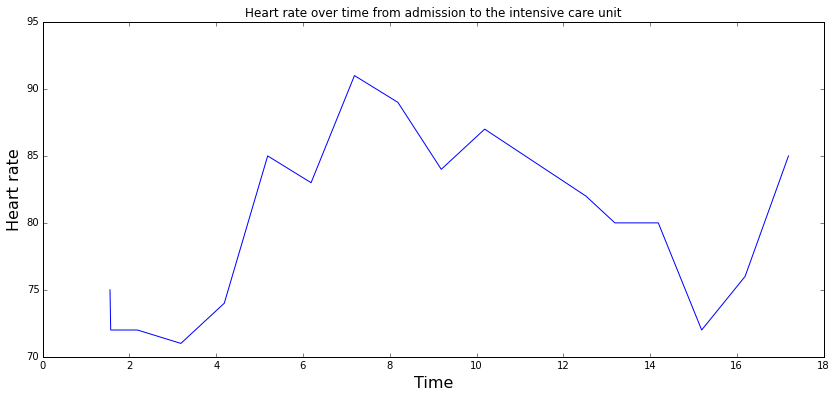

In [31]:
# Set x equal to the times
x_hr = ce.HOURS[ce.LABEL=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.VALUENUM[ce.LABEL=='Heart Rate']

# Plot time against heart rate
plt.figure(figsize=(14, 6))
plt.plot(x_hr,y_hr)


plt.xlabel('Time',fontsize=16)
plt.ylabel('Heart rate',fontsize=16)
plt.title('Heart rate over time from admission to the intensive care unit')

### Task 1

* What is happening to this patient's heart rate?
* Plot respiratory rate over time for the patient.
* Is there anything unusual about the patient's respiratory rate?


In [ ]:
# Exercise 1 here



### Plot 2: Did the patient's vital signs breach any alarm thresholds?

- Alarm systems in the intensive care unit are commonly based on high and low thresholds defined by the carer.
- False alarms are often a problem and so thresholds may be set arbitrarily to reduce alarms.
- As a result, alarm settings carry limited information.

(0, 55)

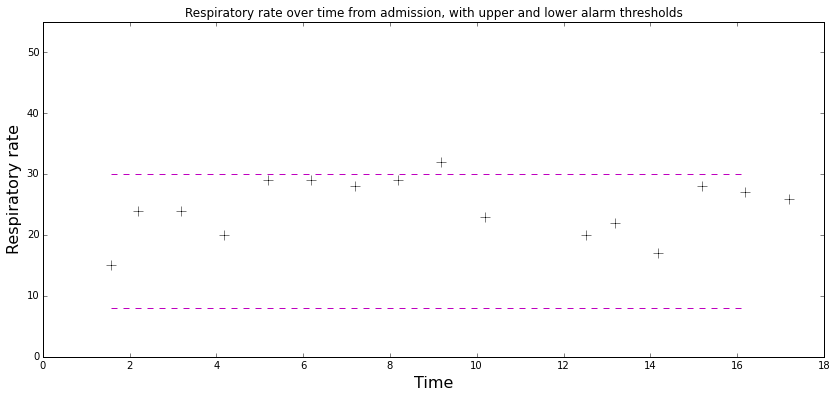

In [37]:
plt.figure(figsize=(14, 6))

plt.plot(ce.HOURS[ce.LABEL=='Respiratory Rate'], 
         ce.VALUENUM[ce.LABEL=='Respiratory Rate'],
         'k+', markersize=10, linewidth=4)

plt.plot(ce.HOURS[ce.LABEL=='Resp Alarm - High'], 
         ce.VALUENUM[ce.LABEL=='Resp Alarm - High'],
         'm--')

plt.plot(ce.HOURS[ce.LABEL=='Resp Alarm - Low'], 
         ce.VALUENUM[ce.LABEL=='Resp Alarm - Low'],
         'm--')

plt.xlabel('Time',fontsize=16)
plt.ylabel('Respiratory rate',fontsize=16)
plt.title('Respiratory rate over time from admission, with upper and lower alarm thresholds')
plt.ylim(0,55)


### Task 2

- Based on the data, does it look like the alarms would have triggered for this patient?


### Plot 3: What is patient's level of consciousness?

- Glasgow Coma Scale (GCS) is a measure of consciousness.
- It is commonly used for monitoring patients in the intensive care unit. 
- It consists of three components: eye response; verbal response; motor response.

In [33]:
# Display the first few rows of the GCS eye response data
ce[ce.LABEL=='GCS - Eye Opening'].head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUENUM,UOM
22,285485,1.753333,GCS - Eye Opening,Spontaneously,4,
47,285485,4.186667,GCS - Eye Opening,Spontaneously,4,
103,285485,8.186667,GCS - Eye Opening,Spontaneously,4,
118,285485,12.186667,GCS - Eye Opening,Spontaneously,4,
155,285485,16.186667,GCS - Eye Opening,Spontaneously,4,


(10, 165)

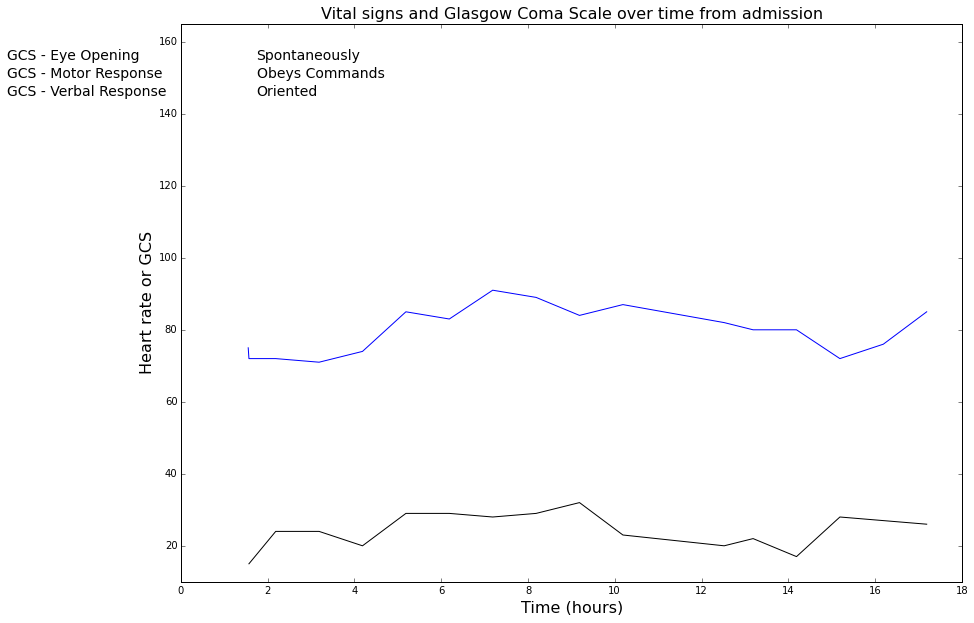

In [45]:
# Prepare the size of the figure
plt.figure(figsize=(14, 10))

# Set x equal to the times
x_hr = ce.HOURS[ce.LABEL=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.VALUENUM[ce.LABEL=='Heart Rate']


plt.plot(x_hr,y_hr)

plt.plot(ce.HOURS[ce.LABEL=='Respiratory Rate'], 
         ce.VALUENUM[ce.LABEL=='Respiratory Rate'],
         'k', markersize=6)

# Add a text label to the y-axis
plt.text(-4,155,'GCS - Eye Opening',fontsize=14)
plt.text(-4,150,'GCS - Motor Response',fontsize=14)
plt.text(-4,145,'GCS - Verbal Response',fontsize=14)   

# Iterate over list of GCS labels, plotting around 1 in 10 to avoid overlap
for i, txt in enumerate(ce.VALUE[ce.LABEL=='GCS - Eye Opening'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.HOURS[ce.LABEL=='GCS - Eye Opening'].values[i],155),fontsize=14)
        
for i, txt in enumerate(ce.VALUE[ce.LABEL=='GCS - Motor Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.HOURS[ce.LABEL=='GCS - Motor Response'].values[i],150),fontsize=14)

for i, txt in enumerate(ce.VALUE[ce.LABEL=='GCS - Verbal Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.HOURS[ce.LABEL=='GCS - Verbal Response'].values[i],145),fontsize=14)

plt.title('Vital signs and Glasgow Coma Scale over time from admission',fontsize=16)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Heart rate or GCS',fontsize=16)
plt.ylim(10,165)


### Task 3

- How is the patient's consciousness changing over time?

# Stop here...

### Plot 2: What other data do we have on the patient?

- Using Pandas 'read_csv function' again, we'll now load the patient outputs data (for example, urine output, drains, dialysis). This data is contained in the outputevents data table.

In [46]:
# OPTION 1: load outputs from the patient
query = """
select de.icustay_id
  , (strftime('%s',de.charttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS
  , di.label
  , de.value
  , de.valueuom
from outputevents de 
inner join icustays ie
  on de.icustay_id = ie.icustay_id
inner join d_items di
  on de.itemid = di.itemid
where de.subject_id = 40036
order by charttime;
"""

oe = pd.read_sql_query(query,conn)

In [13]:
oe.head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUEUOM
0,285485,1.670000,Foley,120,mL
1,285485,4.186667,Foley,80,mL
2,285485,6.186667,Foley,120,mL
3,285485,9.186667,Foley,140,mL
4,285485,11.186667,Foley,200,mL
5,285485,12.186667,Foley,60,mL
6,285485,14.186667,Foley,160,mL
7,285485,16.186667,Foley,100,mL


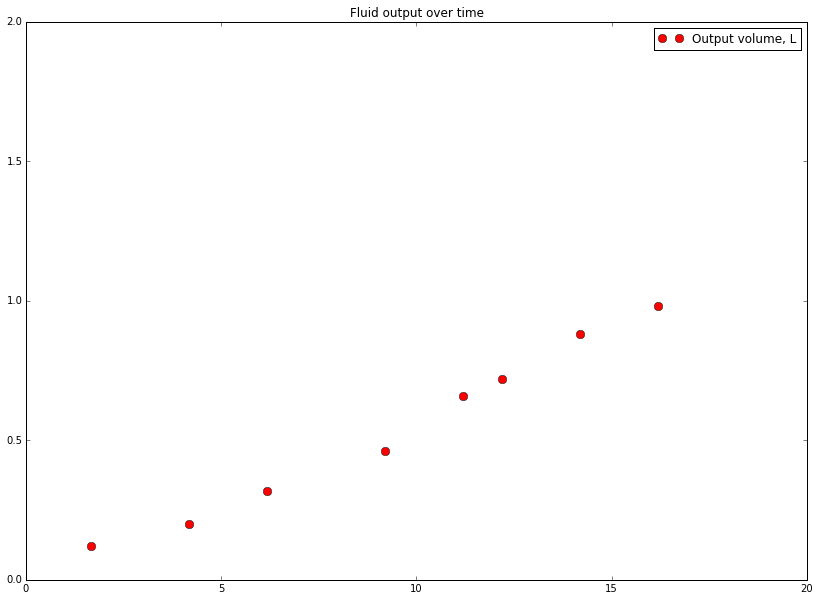

In [47]:
# Prepare the size of the figure
plt.figure(figsize=(14, 10))

plt.title('Fluid output over time')

plt.plot(oe.HOURS, 
         oe.VALUE.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()

To provide context for this plot, it would help to include patient input data. This helps to determine the patient's fluid balance, a key indicator in patient health.

In [48]:
# Load inputs given to the patient (usually intravenously) using the database connection
query = """
select de.icustay_id
  , (strftime('%s',de.starttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS_START
  , (strftime('%s',de.endtime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS_END
  , de.linkorderid
  , di.label
  , de.amount
  , de.amountuom
  , de.rate
  , de.rateuom
from inputevents_mv de 
inner join icustays ie
  on de.icustay_id = ie.icustay_id
inner join d_items di
  on de.itemid = di.itemid
where de.subject_id = 40036
order by endtime;
"""

ie = pd.read_sql_query(query,conn)


In [15]:
ie.head()

,ICUSTAY_ID,HOURS_START,HOURS_END,LINKORDERID,LABEL,AMOUNT,AMOUNTUOM,RATE,RATEUOM
0,285485,4.220000,4.236667,5407282,Cefepime,1,dose,NaN,
1,285485,4.220000,4.236667,5407282,Dextrose 5%,50,mL,NaN,
2,285485,1.586667,8.253333,7047511,NaCl 0.9%,1000,mL,150,mL/hour
3,285485,12.803333,12.870000,5497279,NaCl 0.9%,10,mL,150,mL/hour
4,285485,13.186667,13.203333,6350485,Insulin - Humalog,1,units,NaN,


Note that the column headers are different: we have "HOURS_START" and "HOURS_END". This is because inputs are administered over a fixed period of time.

In [49]:
ie['LABEL'].unique()

array([u'Cefepime', u'Dextrose 5%', u'NaCl 0.9%', u'Insulin - Humalog',
       u'Magnesium Sulfate (Bolus)', u'Magnesium Sulfate',
       u'Heparin Sodium (Prophylaxis)'], dtype=object)

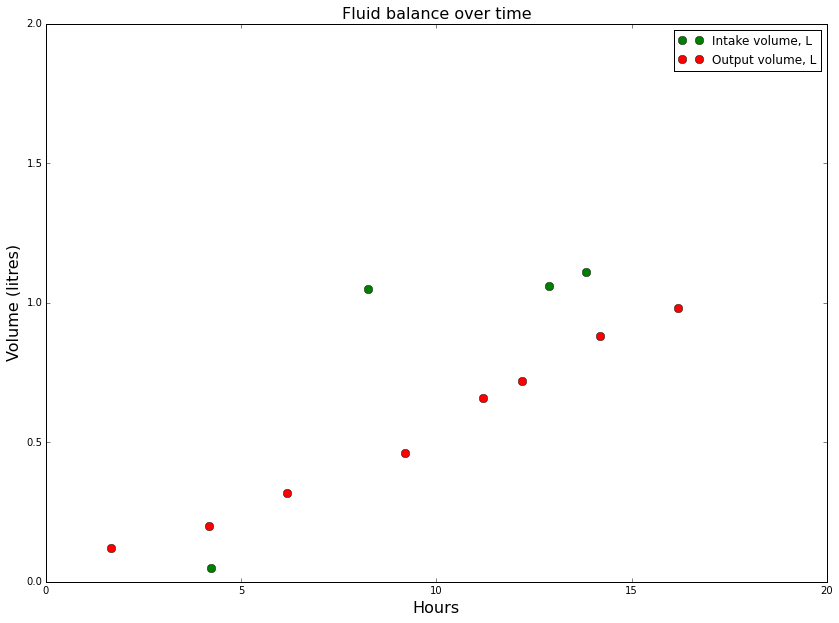

In [50]:
# Prepare the size of the figure
plt.figure(figsize=(14, 10))

# Plot the cumulative input against the cumulative output
plt.plot(ie.HOURS_END[ie.AMOUNTUOM=='mL'], 
         ie.AMOUNT[ie.AMOUNTUOM=='mL'].cumsum()/1000, 
         'go', markersize=8, label='Intake volume, L')

plt.plot(oe.HOURS, 
         oe.VALUE.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

plt.title('Fluid balance over time',fontsize=16)
plt.xlabel('Hours',fontsize=16)
plt.ylabel('Volume (litres)',fontsize=16)
# plt.ylim(0,38)
plt.legend()

As the plot shows, the patient's intake tends to be above their output. There are however periods where input and output are almost one to one. One of the biggest challenges of working with ICU data is that context is everything, so let's look at a treatment (Furosemide/Lasix) which we know will affect this graph.

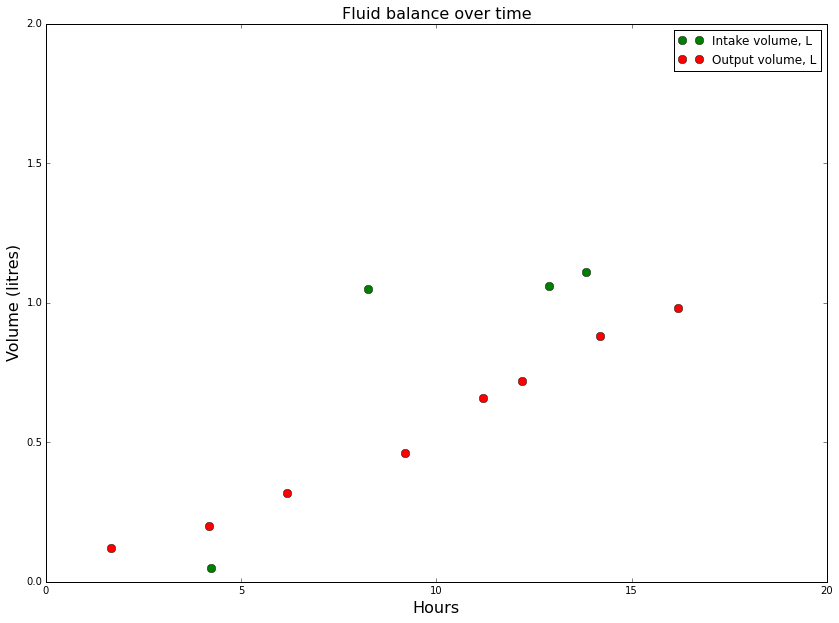

In [51]:
plt.figure(figsize=(14, 10))

# Plot the cumulative input against the cumulative output
plt.plot(ie.HOURS_END[ie.AMOUNTUOM=='mL'], 
         ie.AMOUNT[ie.AMOUNTUOM=='mL'].cumsum()/1000, 
         'go', markersize=8, label='Intake volume, L')

plt.plot(oe.HOURS, 
         oe.VALUE.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

# example on getting two columns from a dataframe: ie[['HOURS_START','HOURS_END']].head()

for i, idx in enumerate(ie.index[ie.LABEL=='Furosemide (Lasix)']):
    plt.plot([ie.HOURS_START[ie.LABEL=='Furosemide (Lasix)'][idx],
             ie.HOURS_END[ie.LABEL=='Furosemide (Lasix)'][idx]],
            [ie.RATE[ie.LABEL=='Furosemide (Lasix)'][idx],
             ie.RATE[ie.LABEL=='Furosemide (Lasix)'][idx]],
            'b-',linewidth=4)
    

plt.title('Fluid balance over time',fontsize=16)
plt.xlabel('Hours',fontsize=16)
plt.ylabel('Volume (litres)',fontsize=16)
# plt.ylim(0,38)
plt.legend()


In [52]:
ie['LABEL'].unique()

array([u'Cefepime', u'Dextrose 5%', u'NaCl 0.9%', u'Insulin - Humalog',
       u'Magnesium Sulfate (Bolus)', u'Magnesium Sulfate',
       u'Heparin Sodium (Prophylaxis)'], dtype=object)

### Exercise 2

* Plot the alarms for the mean arterial pressure ('```Arterial Blood Pressure mean```')
* HINT: you can use ```ce.LABEL.unique()``` to find a list of variable names
* Were the alarm thresholds breached?

In [ ]:
# Exercise 2 here




### Plot 3: Were the patient's other vital signs stable?

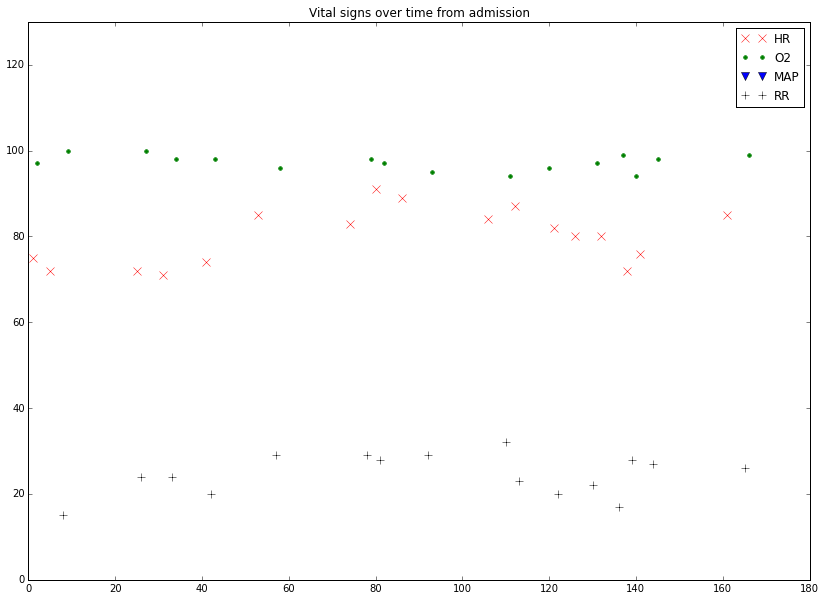

In [53]:
plt.figure(figsize=(14, 10))

plt.plot(ce.index[ce.LABEL=='Heart Rate'], 
         ce.VALUENUM[ce.LABEL=='Heart Rate'],
         'rx', markersize=8, label='HR')

plt.plot(ce.index[ce.LABEL=='O2 saturation pulseoxymetry'], 
         ce.VALUENUM[ce.LABEL=='O2 saturation pulseoxymetry'], 
         'g.', markersize=8, label='O2')

plt.plot(ce.index[ce.LABEL=='Arterial Blood Pressure mean'], 
         ce.VALUENUM[ce.LABEL=='Arterial Blood Pressure mean'], 
         'bv', markersize=8, label='MAP')

plt.plot(ce.index[ce.LABEL=='Respiratory Rate'], 
         ce.VALUENUM[ce.LABEL=='Respiratory Rate'], 
         'k+', markersize=8, label='RR')

plt.title('Vital signs over time from admission')
plt.ylim(0,130)
plt.legend()

### Plot 5: Laboratory measurements

Using Pandas 'read_csv function' again, we'll now load the labevents data.
This data corresponds to measurements made in a laboratory - usually on a sample of patient blood. 

In [58]:
# OPTION 1: load labevents data using the database connection
query = """
SELECT de.subject_id
  , de.charttime
  , di.label, de.value, de.valuenum
  , de.uom
FROM labevents de
INNER JOIN d_labitems di
  ON de.itemid = di.itemid
where de.subject_id = 40036
"""

le = pd.read_sql_query(query,conn)

In [55]:
# preview the labevents data
le.head()

,SUBJECT_ID,CHARTTIME,LABEL,VALUE,VALUENUM,UOM
0,40036,2141-08-01 14:15:00,ANION GAP,18,18.0,mEq/L
1,40036,2141-08-01 14:15:00,BICARBONATE,25,25.0,mEq/L
2,40036,2141-08-01 14:15:00,CHLORIDE,97,97.0,mEq/L
3,40036,2141-08-01 14:15:00,CREATININE,2.5,2.5,mg/dL
4,40036,2141-08-01 14:15:00,GLUCOSE,130,130.0,mg/dL


In [56]:
# preview the ioevents data
le[le.LABEL=='HEMOGLOBIN']

,SUBJECT_ID,CHARTTIME,LABEL,VALUE,VALUENUM,UOM
11,40036,2141-08-01 14:15:00,HEMOGLOBIN,14.3,14.3,g/dL
41,40036,2141-08-01 19:30:00,HEMOGLOBIN,14.4,14.4,g/dL
84,40036,2141-08-02 03:40:00,HEMOGLOBIN,7.6,7.6,g/dL
104,40036,2141-08-02 05:05:00,HEMOGLOBIN,12.4,12.4,g/dL
123,40036,2141-08-03 07:10:00,HEMOGLOBIN,12.6,12.6,g/dL
143,40036,2141-08-04 06:55:00,HEMOGLOBIN,11.8,11.8,g/dL
163,40036,2141-08-05 06:30:00,HEMOGLOBIN,11.6,11.6,g/dL
180,40036,2141-08-06 06:10:00,HEMOGLOBIN,11.9,11.9,g/dL
202,40036,2141-08-07 07:40:00,HEMOGLOBIN,11.8,11.8,g/dL
232,40036,2141-08-09 06:25:00,HEMOGLOBIN,11.9,11.9,g/dL


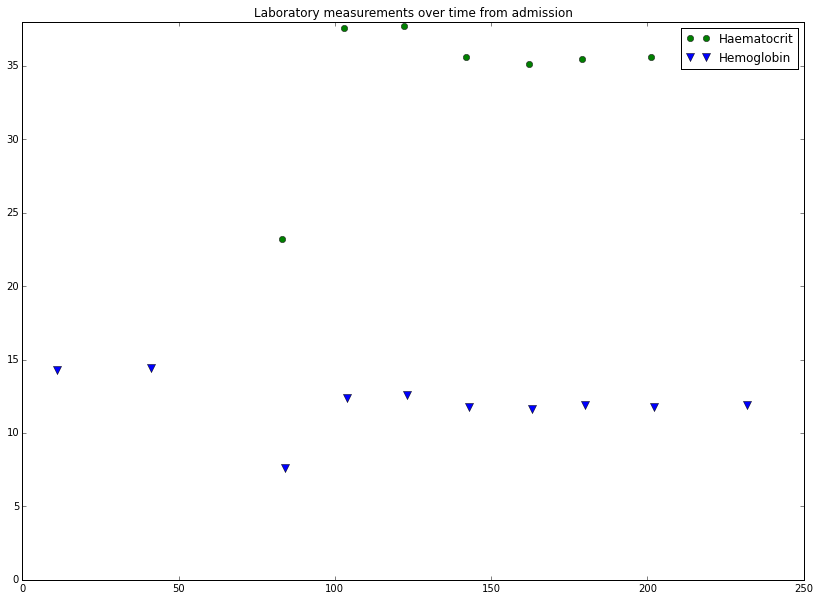

In [57]:
plt.figure(figsize=(14, 10))

plt.plot(le.index[le.LABEL=='HEMATOCRIT'], 
         le.VALUENUM[le.LABEL=='HEMATOCRIT'], 
         'go', markersize=6, label='Haematocrit')

plt.plot(le.index[le.LABEL=='HEMOGLOBIN'], 
         le.VALUENUM[le.LABEL=='HEMOGLOBIN'], 
         'bv', markersize=8, label='Hemoglobin')

plt.title('Laboratory measurements over time from admission')
plt.ylim(0,38)
plt.legend()

## Plot 5: intravenous medications

- Using the Pandas 'read_csv function' again, we'll now load the the ioevents dataset

In [ ]:
# load ioevents
ioe = pd.read_csv('data/example_ioevents.csv',index_col='HOURSSINCEADMISSION_START')

In [ ]:
ioe.head()


In [ ]:
plt.figure(figsize=(14, 10))

plt.plot(ioe.index[ioe.LABEL=='Midazolam (Versed)'], 
         ioe.RATE[ioe.LABEL=='Midazolam (Versed)'], 
         'go', markersize=6, label='Midazolam (Versed)')

plt.plot(ioe.index[ioe.LABEL=='Propofol'], 
         ioe.RATE[ioe.LABEL=='Propofol'], 
         'bv', markersize=8, label='Propofol')

plt.plot(ioe.index[ioe.LABEL=='Fentanyl'], 
         ioe.RATE[ioe.LABEL=='Fentanyl'], 
         'k+', markersize=8, label='Fentanyl')

plt.title('IOevents over time from admission')
plt.ylim(0,380)
plt.legend()

## Plot 6: blood products

- Using Pandas 'read_csv function' again, we'll now load the blood products data

In [ ]:
plt.figure(figsize=(14, 10))

plt.plot(ioe.index[ioe.LABEL=='OR Cryoprecipitate Intake'], 
         ioe.VALUENUM[ioe.LABEL=='OR Cryoprecipitate Intake'], 
         'go', markersize=6, label='OR Cryoprecipitate Intake')

plt.plot(ioe.index[ioe.LABEL=='OR Crystalloid Intake'], 
         ioe.VALUENUM[ioe.LABEL=='OR Crystalloid Intake'], 
         'bv', markersize=8, label='OR Crystalloid Intake')

plt.plot(ioe.index[ioe.LABEL=='OR FFP Intake'], 
         ioe.VALUENUM[ioe.LABEL=='OR FFP Intake'], 
         'k+', markersize=8, label='OR FFP Intake')

plt.plot(ioe.index[ioe.LABEL=='OR Packed RBC Intake'], 
         ioe.VALUENUM[ioe.LABEL=='OR Packed RBC Intake'], 
         'k+', markersize=8, label='OR Packed RBC Intake')

plt.plot(ioe.index[ioe.LABEL=='OR Platelet Intake'], 
         ioe.VALUENUM[ioe.LABEL=='OR Platelet Intake'], 
         'k+', markersize=8, label='OR Platelet Intake')

plt.title('Blood products administered over time from admission')
plt.legend()

### Discharge summary

In [ ]:
# insert discharge summary here...